## Analyze Fiit's Like Study (Line) Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.interpolate import interp1d


sns.set_theme(style = "whitegrid")

In [2]:
_dir = r"DualSensorMouse_Fittslike_RailMAE\Logs"

In [3]:
Try = "4"
UserName = "BMH"

In [4]:
_dirCC = _dir+f"\{UserName}\{Try}"

In [5]:
dirlstWW = os.listdir(_dirCC)

dirlstWW

['BMH_railAngle_010_9']

---

Max Peak at 010_9: 0.786
Mean of Max Peak: 0.786


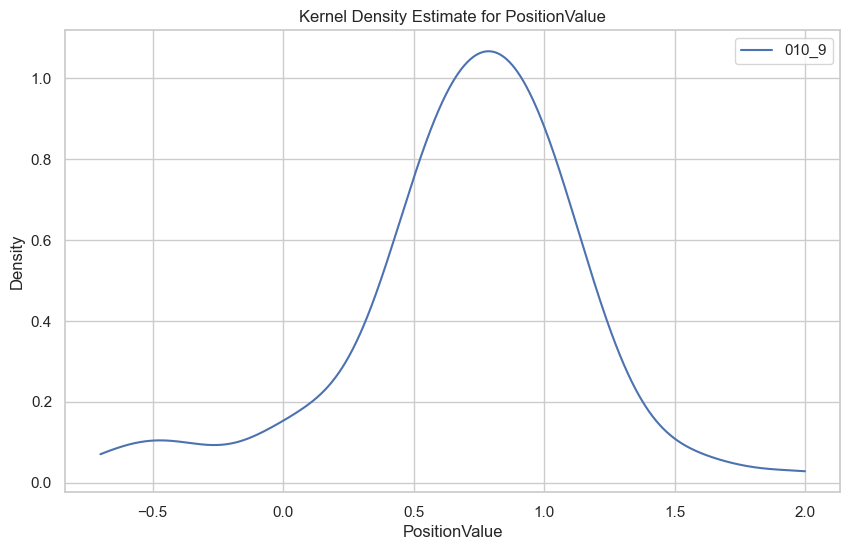

In [6]:
dflstW = [f.path for f in os.scandir(_dirCC) if f.is_dir()]
max_densityV = []

colors = plt.cm.viridis(np.linspace(0, 1, len(dflstW)))

plt.figure(figsize=(10, 6))

for subdir in dflstW:
    subdir_parts = subdir.split('_')
    subdir_info = {
        "User": subdir_parts[2],
        "Type": subdir_parts[3],
        "SenP": subdir_parts[4],
        "Trial": subdir_parts[5]
    }
    subdir_shortened = f"{subdir_info['SenP']}_{subdir_info['Trial']}"
    subdir_path = subdir
    
    subsubdirs = [d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))]
    for subsubdir in subsubdirs:
        subsubdir_path = os.path.join(subdir_path, subsubdir)
        Dirw = os.path.join(subsubdir_path, "Pos_values.csv")

        data = pd.read_csv(Dirw)
        data = data[(data["PositionValue"] >= -1) & (data["PositionValue"] <= 2)]

        kde = gaussian_kde(data["PositionValue"])
        x_values = np.linspace(data["PositionValue"].min(), data["PositionValue"].max(), 1000)
        densities = kde.evaluate(x_values)
        max_density_x = x_values[np.argmax(densities)]
        max_densityV.append(max_density_x)
        print(f"Max Peak at {subdir_shortened}: {max_density_x:.3f}")
        #plt.axvline(x=max_density_x, color='r', linestyle='--', label=f'Max Peak at {max_density_x:.2f}')
        
        plt.plot(x_values, densities, label=subdir_shortened)  # 각 선에 레이블 추가

meanMD = sum(max_densityV) / len(max_densityV)

print(f"Mean of Max Peak: {meanMD:.3f}")

plt.legend()
plt.title('Kernel Density Estimate for PositionValue')
plt.xlabel('PositionValue')
plt.ylabel('Density')
plt.show()

CoM of 010_9: 0.701
CoM of CoMs: 0.701


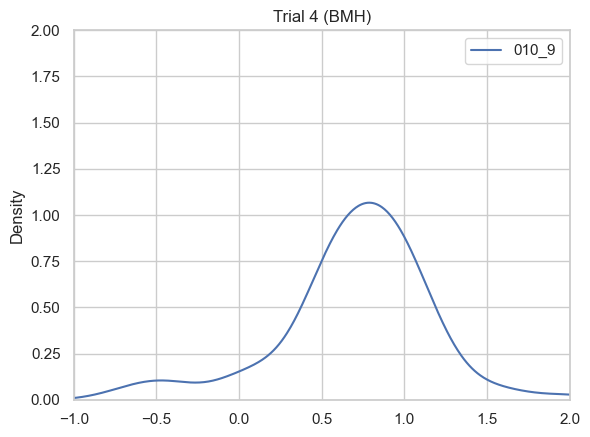

In [7]:
dflstW = []
CoM_values = []

# 각 하위 디렉토리에 대해 또 다른 하위 디렉토리 탐색
for subdir in dirlstWW:
    subdir_parts = subdir.split('_')
    # 필요한 값만 선택하여 저장
    subdir_info = {
        "User": subdir_parts[0],
        "Type": subdir_parts[1],
        "SenP": subdir_parts[2],
        "Trial": subdir_parts[3]
    }
    subdir_shortened = f"{subdir_info['SenP']}_{subdir_info['Trial']}"
    subdir_path = os.path.join(_dirCC, subdir)
    
    # 또 다른 하위 디렉토리 목록 가져오기
    subsubdirs = [d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))]
    # 또 다른 하위 디렉토리에서 Pos_values.csv 파일 찾기
    for subsubdir in subsubdirs:
        subsubdir_path = os.path.join(subdir_path, subsubdir)
        Dirw = os.path.join(subsubdir_path, "Pos_values.csv")
        if os.path.exists(Dirw):
            #if subdir_info["Trial"] == "1":  #통계 조건만 빼서 보고 싶을 때 사용
                dfw = pd.read_csv(Dirw)
                dfw = dfw[(dfw["PositionValue"] >= -1) & (dfw["PositionValue"] <= 2)]
                dflstW.append((dfw, subdir_shortened))  # 수정된 subdir 이름 사용

# 그래프 그리기
for dfw, subdir_shortened in dflstW:
    dfw["PositionValue"].plot.density(label=subdir_shortened)
    
    CoM = dfw["PositionValue"].mean()
    CoM_values.append(CoM)
    
    # CoM 출력
    print(f"CoM of {subdir_shortened}: {CoM:.3f}")

# CoM들의 평균 계산
CCoM = sum(CoM_values) / len(CoM_values)

print(f"CoM of CoMs: {CCoM:.3f}")

plt.legend()
plt.title('Trial '+Try+' ('+UserName+')')
plt.ylim(0, 2.0)
plt.xlim(-1,2)
plt.show()

Minimum X: 76.76767676767676
Minimum Y: 14.580725475654765


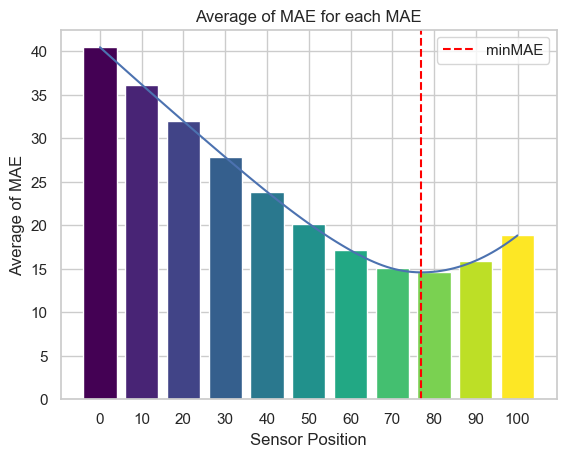

In [8]:
mae_sums = [0] * 11  # MAE0부터 MAE10까지의 값에 대한 누적 합
mae_counts = [0] * 11  # MAE0부터 MAE10까지의 값의 개수

# 각 하위 디렉토리에 대해 또 다른 하위 디렉토리 탐색
for subdir in dirlstWW:
    subdir_parts = subdir.split('_')
    subdir_path = os.path.join(_dirCC, subdir)
    
    # 또 다른 하위 디렉토리 목록 가져오기
    subsubdirs = [d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))]
    # 또 다른 하위 디렉토리에서 Pos_values.csv 파일 찾기
    for subsubdir in subsubdirs:
        subsubdir_path = os.path.join(subdir_path, subsubdir)
        Dirw = os.path.join(subsubdir_path, "Pos_values.csv")
        if os.path.exists(Dirw):
            dfw = pd.read_csv(Dirw)
            dfw = dfw[(dfw["PositionValue"] >= -1) & (dfw["PositionValue"] <= 2)]
            
            # 각 MAE 값들을 더하여 누적 합 계산
            for i in range(11):
                mae_sums[i] += dfw[f'MAE{i}'].sum()
                mae_counts[i] += len(dfw)
                
# 각 MAE 값들의 평균 계산
mae_means = [sum / count for sum, count in zip(mae_sums, mae_counts)]

f = interp1d(range(11), mae_means, kind='cubic') #보간
x_new = np.linspace(0, 10, num=100, endpoint=True)  # 더 많은 데이터 포인트를 생성하여 부드러운 그래프를 위해
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, color='b') #선 그래프 그리기

min_index = np.argmin(y_smooth)
min_x = x_new[min_index]
min_y = y_smooth[min_index]

plt.axvline(x=min_x, color='red', linestyle='--', label='minMAE')  # 최솟값을 나타내는 빨간색 선 추가
print("Minimum X:", min_x*10)
print("Minimum Y:", min_y)

colors = plt.cm.viridis(np.linspace(0, 1, 11))  # viridis 컬러맵을 사용하여 색상 리스트 생성
plt.bar(range(11), mae_means, color=colors)
plt.xlabel('Sensor Position')
plt.ylabel('Average of MAE')
plt.title('Average of MAE for each MAE')
plt.xticks(range(11), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])

plt.legend()

plt.show()